In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import pickle
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,model_from_json , Sequential
from keras.utils import to_categorical
from keras.applications.nasnet import preprocess_input
from keras.applications import NASNetMobile , imagenet_utils
from keras.layers import Activation , Dense , Flatten ,Input, BatchNormalization , Conv2D , MaxPool2D ,MaxPooling2D, Dropout , GlobalAveragePooling2D,Conv1D,MaxPooling1D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping , ReduceLROnPlateau
from keras.regularizers import l2
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline

Our main dataset consists of 24407 images. As per the attached document, we have prepared a subset from it called "**DataSet_for_models**". This dataset contains three folders: train_set , test_set , validation_set and each of these folders contains four subfolders: **CR , PO , LP , ND**

**The goal is to use less data as a result of lower computational costs for the Train model**

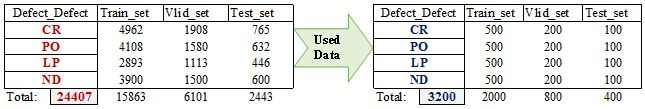

In [ ]:
def count_files(directory):
    if os.path.exists(directory):
        files = os.listdir(directory)
        return(len(files))
    else:
        print("There is no path")

qtydif_dict = {
    'Train_Set ': [   count_files('/content/drive/My Drive/DataSet_for_models/train_set/CR'),
                      count_files('/content/drive/My Drive/DataSet_for_models/train_set/PO'),
                      count_files('/content/drive/My Drive/DataSet_for_models/train_set/LP'),
                      count_files('/content/drive/My Drive/DataSet_for_models/train_set/ND')],

    'Validiation_Set ': [count_files('/content/drive/My Drive/DataSet_for_models/validation_set/CR'),
                         count_files('/content/drive/My Drive/DataSet_for_models/validation_set/PO'),
                         count_files('/content/drive/My Drive/DataSet_for_models/validation_set/LP'),
                         count_files('/content/drive/My Drive/DataSet_for_models/validation_set/ND')],

    'Test_Set ' : [   count_files('/content/drive/My Drive/DataSet_for_models/test_set/CR'),
                      count_files('/content/drive/My Drive/DataSet_for_models/test_set/PO'),
                      count_files('/content/drive/My Drive/DataSet_for_models/test_set/LP'),
                      count_files('/content/drive/My Drive/DataSet_for_models/test_set/ND')]
}
columns = ['CR', 'PO', 'LP', 'ND']
df = pd.DataFrame.from_dict(qtydif_dict, orient='index', columns=columns)
df['Total'] = df.sum(axis=1)
print(df)

                   CR   PO   LP   ND  Total
Train_Set         500  500  500  500   2000
Validiation_Set   200  200  200  200    800
Test_Set          100  100  100  100    400


# **Data Generator**

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_data_dir =     '/content/drive/My Drive/DataSet_for_models/train_set/'
validation_data_dir ='/content/drive/My Drive/DataSet_for_models/validation_set/'
test_dir =           '/content/drive/My Drive/DataSet_for_models/test_set/'

train_batches = train_datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical'
)

validation_batches = val_datagen.flow_from_directory(
    directory=validation_data_dir,
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical'
)

test_batches=test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical'
)

Found 2000 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


## Display samples of data set

Found 2400 images belonging to 4 classes.


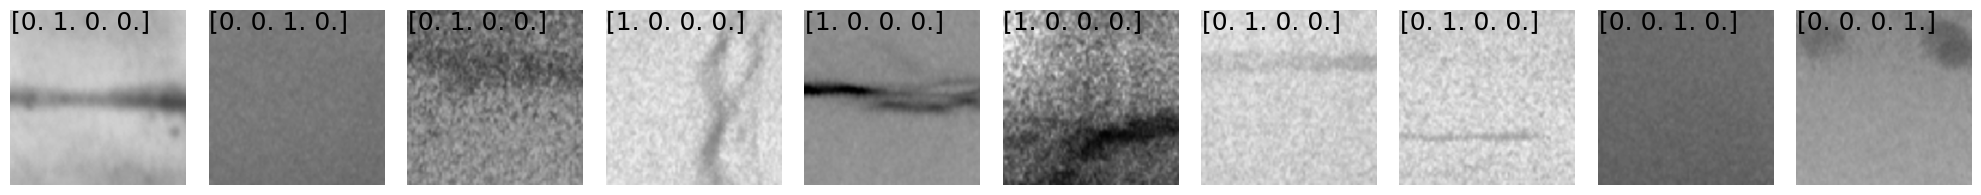

In [ ]:
def plotImage(images_arr, labels):
  fig, axes = plt.subplots(1, 10, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax, label in zip(images_arr, axes, labels):
    ax.imshow(img.astype('uint8'))
    ax.axis('off')
    x, y = ax.get_ylim()
    ax.text(0.5, y + 0.1, f"{label}", va='top', fontsize=18)

  plt.tight_layout()
  plt.show()

train_gen = ImageDataGenerator()
train_batch = train_gen.flow_from_directory(directory=train_data_dir,batch_size=10,class_mode='categorical')
imgs ,labels = next(train_batch)
plotImage(imgs, labels)

### **Overfitting** techniques for all models

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001)

# 1. **Xception** Model  

### Transfer Learning **(import - Compile - Train - Evaluate)**

In [ ]:
from keras.applications.xception import Xception, preprocess_input
# Load the pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add classification layers on top
inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)
xception_model = tf.keras.Model(inputs, outputs)

xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_xception = xception_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
200/200 [==============================] - 567s 3s/step - loss: 0.4241 - accuracy: 0.8730 - val_loss: 0.2752 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - 49s 247ms/step - loss: 0.2473 - accuracy: 0.9285 - val_loss: 0.2480 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - 51s 256ms/step - loss: 0.1978 - accuracy: 0.9485 - val_loss: 0.2449 - val_accuracy: 0.9325 - lr: 0.0010
Epoch 4/20
200/200 [==============================] - 50s 250ms/step - loss: 0.1738 - accuracy: 0.9570 - val_loss: 0.2305 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 5/20
200/200 [==============================] - 52s 258ms/step - loss: 0.1534 - accuracy: 0.9590 - val_loss: 0.1957 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 6/20
200/200 [==============================] - 49s 247ms/step - loss: 0.1420 - accuracy: 0.9640 - val_loss: 0.1919 - val_accuracy: 0.9438 - lr: 0.0010
Epoch 7/20
200/200 [==============================] - 

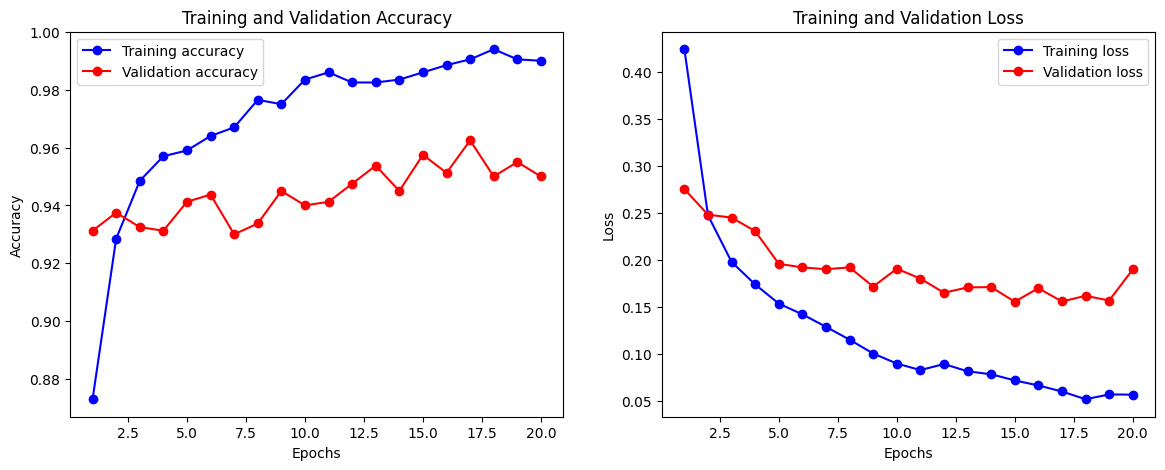

In [ ]:
# Save history_model
with open('/content/drive/My Drive/History_Train_Models/history_xception.pkl', 'wb') as file:
    pickle.dump(history_xception.history, file)

# Extracting data from history
accuracy = history_xception.history['accuracy']
val_accuracy = history_xception.history['val_accuracy']
loss = history_xception.history['loss']
val_loss = history_xception.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Evaluate the model on the Sets
train_score_xception = xception_model.evaluate(train_batches,steps=len(train_batches), verbose=0)
val_score_xception   = xception_model.evaluate(validation_batches,steps=len(validation_batches), verbose=0)
test_score_xception  = xception_model.evaluate(test_batches, steps=len(test_batches), verbose=0)

print(f'Training loss xception model  : {train_score_xception[0]} ... Training accuracy xception model:   {train_score_xception[1]}')
print(f'Validation loss xception model: {val_score_xception[0]}   ... Validation accuracy xception model: {val_score_xception[1]}')
print(f'Test loss xception model      : {test_score_xception[0]}  ... Test accuracy xception model:       {test_score_xception[1]}')

Training loss xception model : 0.05187641829252243 ... Training accuracy xception model: 0.9919999837875366
Validation loss xception model: 0.18974652886390686 ... Validation accuracy xception model: 0.949999988079071
Test loss xception model: 0.18960249423980713 ... Test accuracy xception model: 0.9474999904632568


# 2. **NASNet Mobile** Model  

### Transfer Learning **(import - Compile - Train - Evaluate)**

In [ ]:
from keras.applications import NASNetMobile

base_model = tf.keras.applications.nasnet.NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freaze Base Layers
for layer in base_model.layers:
    layer.trainable = False

# Add GlobalAveragePooling2D
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# Add fully connected
fc_layer1 = tf.keras.layers.Dense(512, activation='relu')(global_average_layer)
dropout_layer = tf.keras.layers.Dropout(0.5)(fc_layer1)
fc_layer2 = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(dropout_layer)

nasnet_model = tf.keras.Model(inputs=base_model.input, outputs=fc_layer2)

nasnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history_nasnet = nasnet_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

19993432/19993432 [==============================] - 0s 0us/step
Epoch 1/20
200/200 [==============================] - 615s 3s/step - loss: 0.4626 - accuracy: 0.8540 - val_loss: 0.2797 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - 24s 120ms/step - loss: 0.2867 - accuracy: 0.9125 - val_loss: 0.2182 - val_accuracy: 0.9350 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - 24s 118ms/step - loss: 0.2421 - accuracy: 0.9255 - val_loss: 0.2483 - val_accuracy: 0.9075 - lr: 0.0010
Epoch 4/20
200/200 [==============================] - 24s 118ms/step - loss: 0.2401 - accuracy: 0.9290 - val_loss: 0.2465 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 5/20
200/200 [==============================] - 24s 118ms/step - loss: 0.2013 - accuracy: 0.9445 - val_loss: 0.1855 - val_accuracy: 0.9388 - lr: 0.0010
Epoch 6/20
200/200 [==============================] - 23s 117ms/step - loss: 0.1766 - accuracy: 0.9495 - val_loss: 0.1929 - val_accuracy: 0.9375 - 

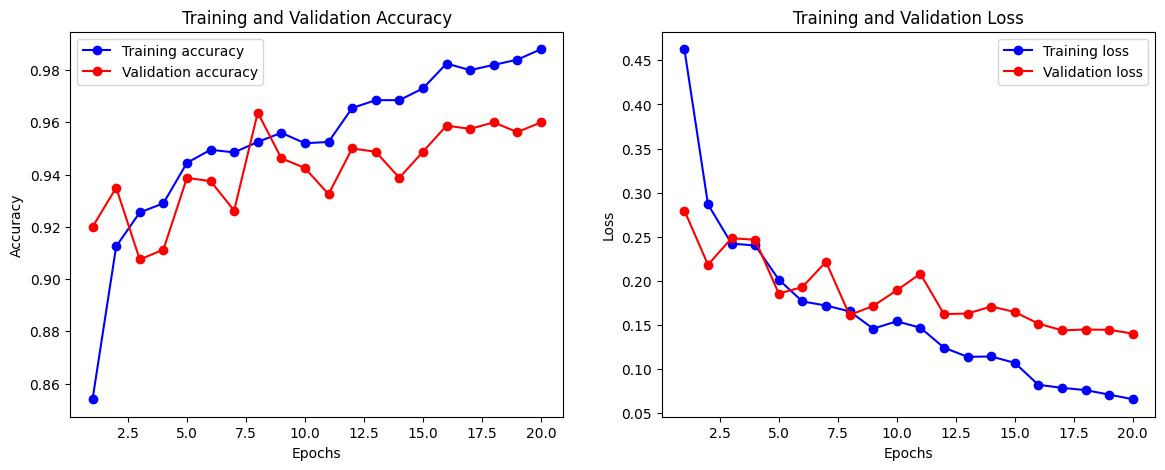

In [ ]:
# Save history_model
with open('/content/drive/My Drive/History_Train_Models/history_nasnet.pkl', 'wb') as file:
    pickle.dump(history_nasnet.history, file)

# Extracting data from history
accuracy = history_nasnet.history['accuracy']
val_accuracy = history_nasnet.history['val_accuracy']
loss = history_nasnet.history['loss']
val_loss = history_nasnet.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the Sets
train_score_nasnet = nasnet_model.evaluate(train_batches,steps=len(train_batches), verbose=0)
val_score_nasnet   = nasnet_model.evaluate(validation_batches,steps=len(validation_batches), verbose=0)
test_score_nasnet  = nasnet_model.evaluate(test_batches, steps=len(test_batches), verbose=0)

print(f'Training loss Nasnet Mobile: {train_score_nasnet[0]} ... Training accuracy Nasnet Mobile: {train_score_nasnet[1]}')
print(f'Validation loss Nasnet Mobile: {val_score_nasnet[0]} ... Validation accuracy Nasnet Mobile: {val_score_nasnet[1]}')
print(f'Test loss Nasnet Mobile: {test_score_nasnet[0]} ... Test accuracy Nasnet Mobile: {test_score_nasnet[1]}')

Training loss Nasnet Mobile: 0.05425432696938515 ... Training accuracy Nasnet Mobile: 0.9919999837875366
Validation loss Nasnet Mobile: 0.14013193547725677 ... Validation accuracy Nasnet Mobile: 0.9599999785423279
Test loss Nasnet Mobile: 0.1306684911251068 ... Test accuracy Nasnet Mobile: 0.9474999904632568


# 3. **DenseNet 201** Model  

### Transfer Learning **(import - Compile - Train - Evaluate)**

In [ ]:
from keras.applications import DenseNet201

base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)

# Create final Model
densenet_model = Model(inputs=base_model.input, outputs=predictions)

# Freze Layers (base model)
for layer in base_model.layers:
    layer.trainable = False
densenet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history_densnet = densenet_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

74836368/74836368 [==============================] - 0s 0us/step
Epoch 1/20
200/200 [==============================] - 111s 509ms/step - loss: 0.4869 - accuracy: 0.8385 - val_loss: 0.2601 - val_accuracy: 0.9388 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - 94s 470ms/step - loss: 0.2808 - accuracy: 0.9135 - val_loss: 0.2226 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - 94s 470ms/step - loss: 0.2358 - accuracy: 0.9300 - val_loss: 0.1881 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 4/20
200/200 [==============================] - 94s 468ms/step - loss: 0.2035 - accuracy: 0.9390 - val_loss: 0.1978 - val_accuracy: 0.9475 - lr: 0.0010
Epoch 5/20
200/200 [==============================] - 94s 470ms/step - loss: 0.1998 - accuracy: 0.9425 - val_loss: 0.1596 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 6/20
200/200 [==============================] - 92s 460ms/step - loss: 0.1576 - accuracy: 0.9590 - val_loss: 0.1626 - val_accuracy: 0.9575

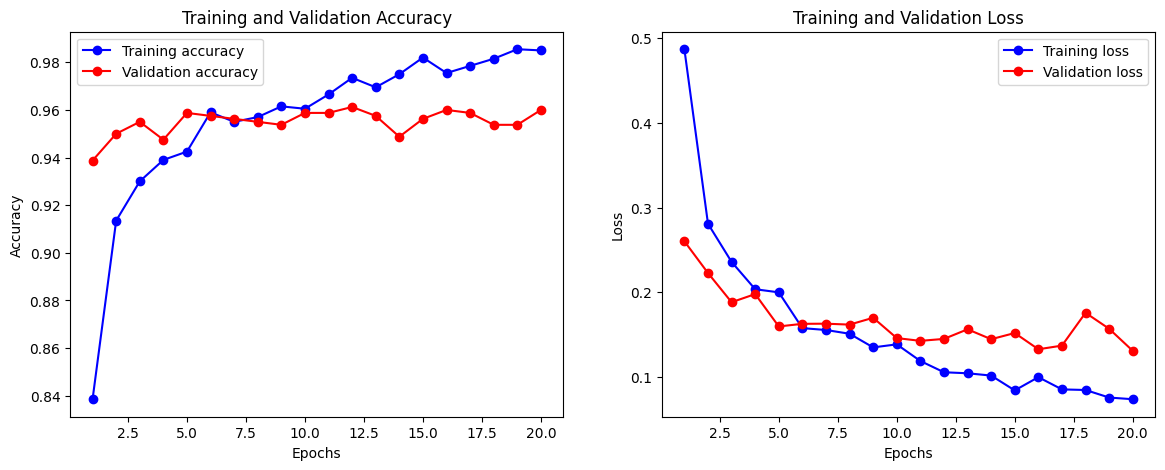

In [ ]:
# Save history_model
with open('/content/drive/My Drive/History_Train_Models/history_densnet.pkl', 'wb') as file:
    pickle.dump(history_densnet.history, file)

# Extracting data from history
accuracy = history_densnet.history['accuracy']
val_accuracy = history_densnet.history['val_accuracy']
loss = history_densnet.history['loss']
val_loss = history_densnet.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the Sets
train_score_densnet = densenet_model.evaluate(train_batches,steps=len(train_batches), verbose=0)
val_score_densnet   = densenet_model.evaluate(validation_batches,steps=len(validation_batches), verbose=0)
test_score_densnet  = densenet_model.evaluate(test_batches, steps=len(test_batches), verbose=0)

print(f'Training loss DensNet 201 Model: {train_score_densnet[0]} ... Training accuracy DensNet 201 Model: {train_score_densnet[1]}')
print(f'Validation loss DensNet 201 Model: {val_score_densnet[0]} ... Validation accuracy DensNet 201 Model: {val_score_densnet[1]}')
print(f'Test loss DensNet 201 Model: {test_score_densnet[0]} ... Test accuracy DensNet 201 Model: {test_score_densnet[1]}')

Training loss DensNet 201 Model: 0.04903517663478851 ... Training accuracy DensNet 201 Model: 0.9950000047683716
Validation loss DensNet 201 Model: 0.13078725337982178 ... Validation accuracy DensNet 201 Model: 0.9599999785423279
Test loss DensNet 201 Model: 0.10820647329092026 ... Test accuracy DensNet 201 Model: 0.9674999713897705


# 4. **MobileNet V2** Model  

### Transfer Learning **(import - Compile - Train - Evaluate)**

In [ ]:
from keras.applications import MobileNetV2

input_tensor = Input(shape=(224, 224, 3))
base_model1 = MobileNetV2(input_tensor=input_tensor, weights='imagenet', include_top=False)

x = base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)

mobile_model = Model(inputs=base_model1.input, outputs=predictions)

# Freze Layers
for layer in base_model1.layers:
    layer.trainable = False

mobile_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history_mobilenet = mobile_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/20
200/200 [==============================] - 698s 3s/step - loss: 0.8830 - accuracy: 0.6835 - val_loss: 0.5292 - val_accuracy: 0.8238 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - 101s 503ms/step - loss: 0.6104 - accuracy: 0.7750 - val_loss: 0.5641 - val_accuracy: 0.7837 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - 113s 564ms/step - loss: 0.5386 - accuracy: 0.8155 - val_loss: 0.4612 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 4/20
200/200 [==============================] - 102s 512ms/step - loss: 0.5043 - accuracy: 0.8235 - val_loss: 0.4547 - val_accuracy: 0.8487 - lr: 0.0010
Epoch 5/20
200/200 [==============================] - 105s 526ms/step - loss: 0.4602 - accuracy: 0.8355 - val_loss: 0.4272 - val_accuracy: 0.8537 - lr: 0.0010
Epoch 6/20
200/200 [==============================] - 113s 563ms/step - loss: 0.4446 - accuracy: 0.8300 - val_loss: 0.4044 - val_accuracy: 0.8600

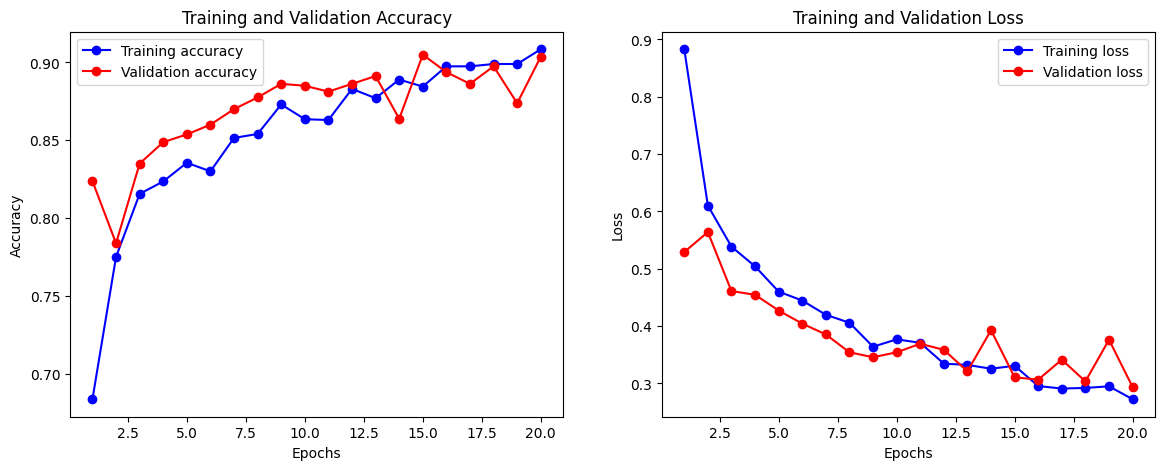

In [ ]:
# Save history_model
with open('/content/drive/My Drive/History_Train_Models/history_mobilenet.pkl', 'wb') as file:
    pickle.dump(history_mobilenet.history, file)

# Extracting data from history
accuracy = history_mobilenet.history['accuracy']
val_accuracy = history_mobilenet.history['val_accuracy']
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the Sets
train_score_mobilenet = mobile_model.evaluate(train_batches,steps=len(train_batches), verbose=0)
val_score_mobilenet   = mobile_model.evaluate(validation_batches,steps=len(validation_batches), verbose=0)
test_score_mobilenet  = mobile_model.evaluate(test_batches, steps=len(test_batches), verbose=0)

print(f'Training loss MobileNet V2: {train_score_mobilenet[0]} ... Training accuracy MobileNet V2: {train_score_mobilenet[1]}')
print(f'Validation loss MobileNet V2: {val_score_mobilenet[0]} ... Validation accuracy MobileNet V2: {val_score_mobilenet[1]}')
print(f'Test loss MobileNet V2: {test_score_mobilenet[0]} ... Test accuracy MobileNet V2: {test_score_mobilenet[1]}')

Training loss MobileNet V2: 0.1883305311203003 ... Training accuracy MobileNet V2: 0.9459999799728394
Validation loss MobileNet V2: 0.2936876118183136 ... Validation accuracy MobileNet V2: 0.9037500023841858
Test loss MobileNet V2: 0.2540985941886902 ... Test accuracy MobileNet V2: 0.9225000143051147


# 5. **ResNet 50** Model  

### Transfer Learning **(import - Compile - Train - Evaluate)**

In [ ]:
from keras.applications.resnet50 import ResNet50, preprocess_input

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add classification layers on top
inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)
resnet_model = tf.keras.Model(inputs, outputs)

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_resnet = resnet_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/20
200/200 [==============================] - 455s 2s/step - loss: 1.5436 - accuracy: 0.2745 - val_loss: 1.3810 - val_accuracy: 0.2688 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - 445s 2s/step - loss: 1.3878 - accuracy: 0.3015 - val_loss: 1.3691 - val_accuracy: 0.3175 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - 460s 2s/step - loss: 1.3691 - accuracy: 0.3120 - val_loss: 1.3475 - val_accuracy: 0.4675 - lr: 0.0010
Epoch 4/20
200/200 [==============================] - 460s 2s/step - loss: 1.3524 - accuracy: 0.3395 - val_loss: 1.3481 - val_accuracy: 0.2463 - lr: 0.0010
Epoch 5/20
200/200 [==============================] - 445s 2s/step - loss: 1.3419 - accuracy: 0.3415 - val_loss: 1.3273 - val_accuracy: 0.3950 - lr: 0.0010
Epoch 6/20
200/200 [==============================] - 451s 2s/step - loss: 1.3353 - accuracy: 0.3435 - val_loss: 1.3185 - val_accuracy: 0.3887 - lr: 0.0010

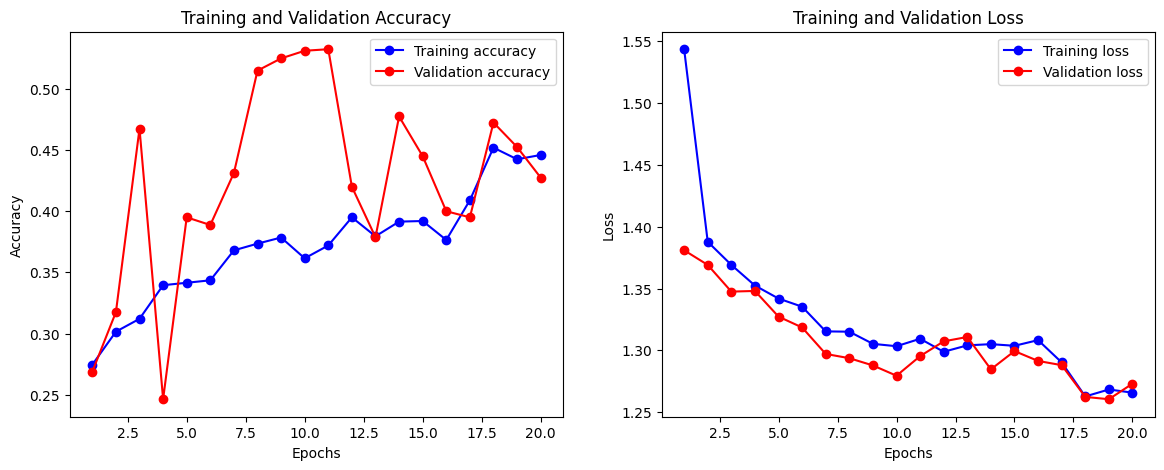

In [ ]:
# Save history_model
with open('/content/drive/My Drive/History_Train_Models/history_resnet.pkl', 'wb') as file:
    pickle.dump(history_resnet.history, file)

# Extracting data from history
accuracy = history_resnet.history['accuracy']
val_accuracy = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the Sets
train_score_resnet = resnet_model.evaluate(train_batches,steps=len(train_batches), verbose=0)
val_score_resnet   = resnet_model.evaluate(validation_batches,steps=len(validation_batches), verbose=0)
test_score_resnet  = resnet_model.evaluate(test_batches, steps=len(test_batches), verbose=0)

print(f'Training loss ResNet50 model : {train_score_resnet[0]} ... Training accuracy ResNet50 model: {train_score_resnet[1]}')
print(f'Validation loss ResNet50 model: {val_score_resnet[0]} ... Validation accuracy ResNet50 model: {val_score_resnet[1]}')
print(f'Test loss ResNet50 model: {test_score_resnet[0]} ... Test accuracy ResNet50 model: {test_score_resnet[1]}')


Training loss ResNet50 model : 1.256860613822937 ... Training accuracy ResNet50 model: 0.44350001215934753
Validation loss ResNet50 model: 1.2730897665023804 ... Validation accuracy ResNet50 model: 0.42750000953674316
Test loss ResNet50 model: 1.26455819606781 ... Test accuracy ResNet50 model: 0.41499999165534973


# 6. **VGG 16** Model  

### Transfer Learning **(import - Compile - Train - Evaluate)**

In [ ]:
from keras.applications.vgg16 import VGG16, preprocess_input

# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add classification layers on top
inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)
vgg16_model = tf.keras.Model(inputs, outputs)

vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_vgg16 = vgg16_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/20
200/200 [==============================] - 1544s 8s/step - loss: 1.2360 - accuracy: 0.5045 - val_loss: 1.0882 - val_accuracy: 0.6037 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - 1519s 8s/step - loss: 1.0706 - accuracy: 0.5970 - val_loss: 1.0078 - val_accuracy: 0.6212 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - 1517s 8s/step - loss: 1.0204 - accuracy: 0.6245 - val_loss: 0.9808 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/20
200/200 [==============================] - 1549s 8s/step - loss: 0.9848 - accuracy: 0.6360 - val_loss: 0.9318 - val_accuracy: 0.6587 - lr: 0.0010
Epoch 5/20
200/200 [==============================] - 1517s 8s/step - loss: 0.9359 - accuracy: 0.6565 - val_loss: 0.8986 - val_accuracy: 0.6687 - lr: 0.0010
Epoch 6/20
200/200 [==============================] - 1519s 8s/step - loss: 0.9282 - accuracy: 0.6510 - val_loss: 0.9789 - val_accuracy: 0.6212 - lr: 

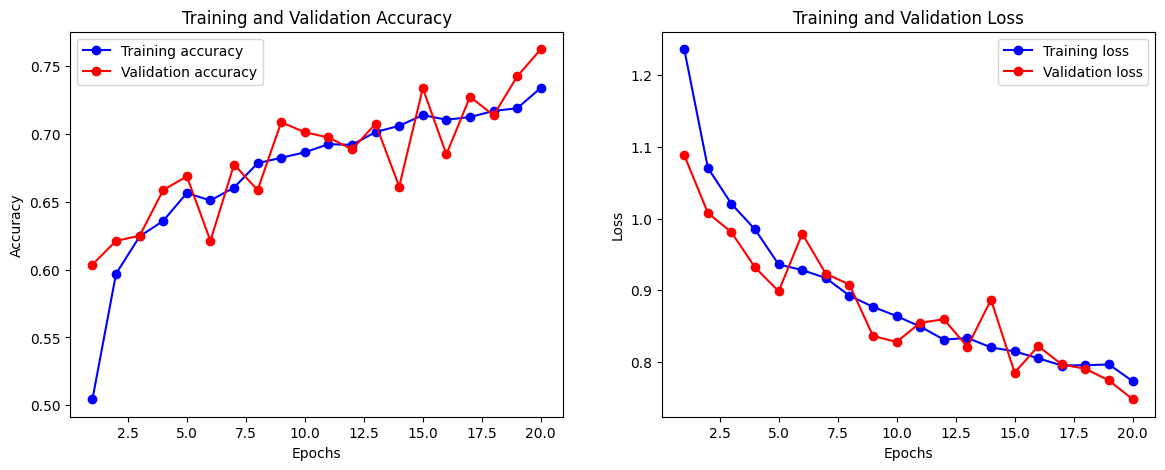

In [ ]:
# Save history_model
with open('/content/drive/My Drive/History_Train_Models/history_vgg16.pkl', 'wb') as file:
    pickle.dump(history_vgg16.history, file)

# Extracting data from history
accuracy = history_vgg16.history['accuracy']
val_accuracy = history_vgg16.history['val_accuracy']
loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the Sets
train_score_vgg16 = vgg16_model.evaluate(train_batches,steps=len(train_batches), verbose=0)
val_score_vgg16   = vgg16_model.evaluate(validation_batches,steps=len(validation_batches), verbose=0)
test_score_vgg16  = vgg16_model.evaluate(test_batches, steps=len(test_batches), verbose=0)

print(f'Training loss VGG16 model : {train_score_vgg16[0]} ... Training accuracy VGG16 model: {train_score_vgg16[1]}')
print(f'Validation loss VGG16 model: {val_score_vgg16[0]} ... Validation accuracy VGG16 model: {val_score_vgg16[1]}')
print(f'Test loss VGG16 model: {test_score_vgg16[0]} ... Test accuracy VGG16 model: {test_score_vgg16[1]}')


Training loss VGG16 model : 0.7078214287757874 ... Training accuracy VGG16 model: 0.7714999914169312
Validation loss VGG16 model: 0.7481436729431152 ... Validation accuracy VGG16 model: 0.762499988079071
Test loss VGG16 model: 0.7669336199760437 ... Test accuracy VGG16 model: 0.7275000214576721


# 7. **VGG 19** Model  

### Transfer Learning **(import - Compile - Train - Evaluate)**

In [ ]:
from keras.applications.vgg19 import VGG19, preprocess_input

# Load the pre-trained VGG19 model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add classification layers on top
inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)
vgg19_model = tf.keras.Model(inputs, outputs)

vgg19_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_vgg19 = vgg19_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/20
200/200 [==============================] - 71s 352ms/step - loss: 1.2532 - accuracy: 0.4615 - val_loss: 1.1351 - val_accuracy: 0.5512 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - 69s 344ms/step - loss: 1.1413 - accuracy: 0.5290 - val_loss: 1.0924 - val_accuracy: 0.5587 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - 69s 345ms/step - loss: 1.1041 - accuracy: 0.5550 - val_loss: 1.0501 - val_accuracy: 0.5925 - lr: 0.0010
Epoch 4/20
200/200 [==============================] - 69s 345ms/step - loss: 1.0889 - accuracy: 0.5600 - val_loss: 1.0260 - val_accuracy: 0.6050 - lr: 0.0010
Epoch 5/20
200/200 [==============================] - 67s 335ms/step - loss: 1.0616 - accuracy: 0.5735 - val_loss: 1.0079 - val_accuracy: 0.6075 - lr: 0.0010
Epoch 6/20
200/200 [==============================] - 68s 340ms/step - loss: 1.0428 - accuracy: 0.5845 - val_loss: 0.9919 - val_accuracy: 0.5938 

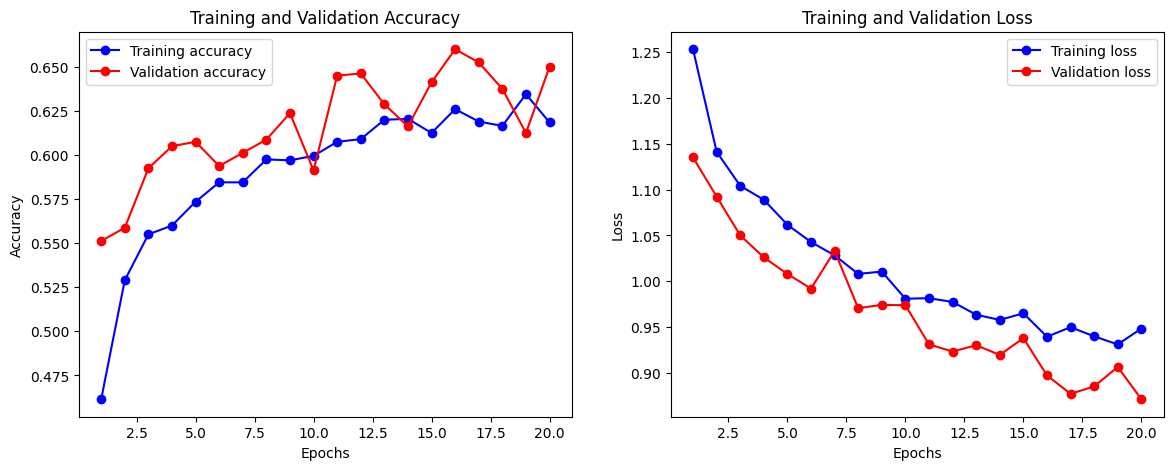

In [ ]:
# Extracting data from history
accuracy = history_vgg19.history['accuracy']
val_accuracy = history_vgg19.history['val_accuracy']
loss = history_vgg19.history['loss']
val_loss = history_vgg19.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the Sets
train_score_vgg19 = vgg19_model.evaluate(train_batches,steps=len(train_batches), verbose=0)
val_score_vgg19   = vgg19_model.evaluate(validation_batches,steps=len(validation_batches), verbose=0)
test_score_vgg19  = vgg19_model.evaluate(test_batches, steps=len(test_batches), verbose=0)

print(f'Training loss VGG16 model : {train_score_vgg19[0]} ... Training accuracy VGG16 model: {train_score_vgg19[1]}')
print(f'Validation loss VGG16 model: {val_score_vgg19[0]} ... Validation accuracy VGG16 model: {val_score_vgg19[1]}')
print(f'Test loss VGG16 model: {test_score_vgg19[0]} ... Test accuracy VGG16 model: {test_score_vgg19[1]}')


Training loss VGG16 model : 0.8715255856513977 ... Training accuracy VGG16 model: 0.640500009059906
Validation loss VGG16 model: 0.8712159991264343 ... Validation accuracy VGG16 model: 0.6499999761581421
Test loss VGG16 model: 0.8884939551353455 ... Test accuracy VGG16 model: 0.6050000190734863


# 8. **ResNet50V2** Model  

### Transfer Learning **(import - Compile - Train - Evaluate)**

In [ ]:
from keras.applications.resnet_v2 import ResNet50V2, preprocess_input

base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the base model
base_model.trainable = False

# Add classification layers on top
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

# Create the model
resnet_model = tf.keras.Model(inputs, outputs)

# Compile the model
resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model
history_resnet = resnet_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

94668760/94668760 [==============================] - 0s 0us/step
Epoch 1/20
200/200 [==============================] - 618s 3s/step - loss: 0.4048 - accuracy: 0.8750 - val_loss: 0.2309 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - 41s 204ms/step - loss: 0.2013 - accuracy: 0.9505 - val_loss: 0.1738 - val_accuracy: 0.9513 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - 38s 192ms/step - loss: 0.1682 - accuracy: 0.9550 - val_loss: 0.1700 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 4/20
200/200 [==============================] - 38s 189ms/step - loss: 0.1398 - accuracy: 0.9630 - val_loss: 0.1573 - val_accuracy: 0.9525 - lr: 0.0010
Epoch 5/20
200/200 [==============================] - 38s 188ms/step - loss: 0.1047 - accuracy: 0.9745 - val_loss: 0.1496 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 6/20
200/200 [==============================] - 38s 190ms/step - loss: 0.0835 - accuracy: 0.9820 - val_loss: 0.1490 - val_accuracy: 0.9588 - 

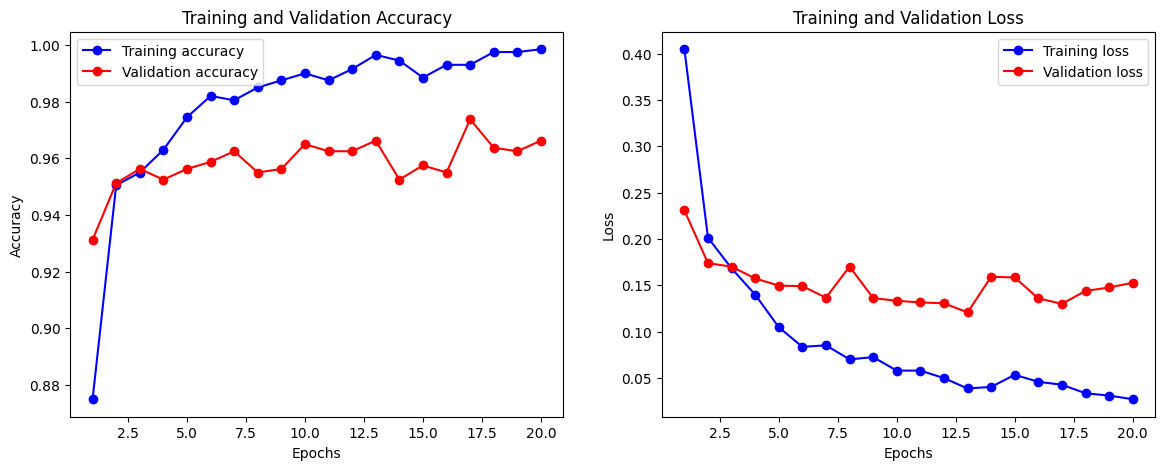

In [ ]:
# Extracting data from history
accuracy = history_resnet.history['accuracy']
val_accuracy = history_resnet.history['val_accuracy']
loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the Sets
train_score_resnet = resnet_model.evaluate(train_batches,steps=len(train_batches), verbose=0)
val_score_resnet   = resnet_model.evaluate(validation_batches,steps=len(validation_batches), verbose=0)
test_score_resnet  = resnet_model.evaluate(test_batches, steps=len(test_batches), verbose=0)

print(f'Training loss ResNet50 model : {train_score_resnet[0]} ... Training accuracy ResNet50 model: {train_score_resnet[1]}')
print(f'Validation loss ResNet50 model: {val_score_resnet[0]} ... Validation accuracy ResNet50 model: {val_score_resnet[1]}')
print(f'Test loss ResNet50 model: {test_score_resnet[0]} ... Test accuracy ResNet50 model: {test_score_resnet[1]}')

Training loss ResNet50 model : 0.0225587897002697 ... Training accuracy ResNet50 model: 0.9990000128746033
Validation loss ResNet50 model: 0.15273241698741913 ... Validation accuracy ResNet50 model: 0.9662500023841858
Test loss ResNet50 model: 0.11557205021381378 ... Test accuracy ResNet50 model: 0.9725000262260437


# 9. **Incpetion V3** Model  

### Transfer Learning **(import - Compile - Train - Evaluate)**

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

# Load the pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add classification layers on top
inputs = tf.keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)
inception_model = tf.keras.Model(inputs, outputs)

inception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_inception = inception_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

87910968/87910968 [==============================] - 0s 0us/step
Epoch 1/20
200/200 [==============================] - 34s 152ms/step - loss: 0.5105 - accuracy: 0.8370 - val_loss: 0.2920 - val_accuracy: 0.9125 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - 29s 146ms/step - loss: 0.3054 - accuracy: 0.9020 - val_loss: 0.2789 - val_accuracy: 0.9100 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - 29s 145ms/step - loss: 0.2422 - accuracy: 0.9265 - val_loss: 0.2531 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 4/20
200/200 [==============================] - 29s 144ms/step - loss: 0.2108 - accuracy: 0.9330 - val_loss: 0.2243 - val_accuracy: 0.9237 - lr: 0.0010
Epoch 5/20
200/200 [==============================] - 29s 145ms/step - loss: 0.1948 - accuracy: 0.9355 - val_loss: 0.2264 - val_accuracy: 0.9212 - lr: 0.0010
Epoch 6/20
200/200 [==============================] - 29s 145ms/step - loss: 0.1630 - accuracy: 0.9460 - val_loss: 0.2131 - val_accuracy: 0.9325 

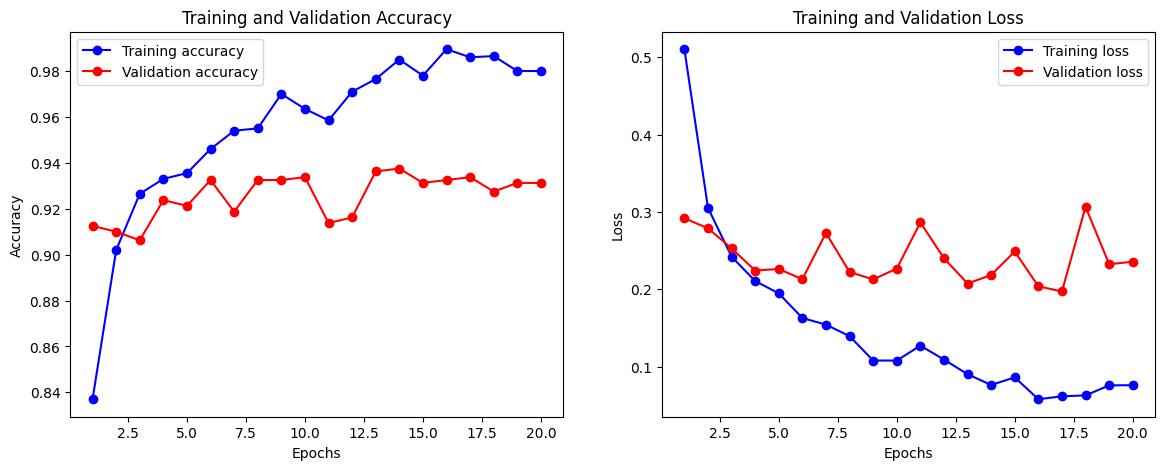

In [ ]:
# Save history_model
with open('/content/drive/My Drive/History_Train_Models/history_inception.pkl', 'wb') as file:
    pickle.dump(history_inception.history, file)

# Extracting data from history
accuracy = history_inception.history['accuracy']
val_accuracy = history_inception.history['val_accuracy']
loss = history_inception.history['loss']
val_loss = history_inception.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the Sets
train_score_inception = inception_model.evaluate(train_batches, steps=len(train_batches), verbose=0)
val_score_inception   = inception_model.evaluate(validation_batches, steps=len(validation_batches), verbose=0)
test_score_inception  = inception_model.evaluate(test_batches, steps=len(test_batches), verbose=0)

print(f'Training loss InceptionV3 model : {train_score_inception[0]} ... Training accuracy InceptionV3 model: {train_score_inception[1]}')
print(f'Validation loss InceptionV3 model: {val_score_inception[0]} ... Validation accuracy InceptionV3 model: {val_score_inception[1]}')
print(f'Test loss InceptionV3 model: {test_score_inception[0]} ... Test accuracy InceptionV3 model: {test_score_inception[1]}')

Training loss InceptionV3 model : 0.03167510777711868 ... Training accuracy InceptionV3 model: 0.9980000257492065
Validation loss InceptionV3 model: 0.23571349680423737 ... Validation accuracy InceptionV3 model: 0.9312499761581421
Test loss InceptionV3 model: 0.20034776628017426 ... Test accuracy InceptionV3 model: 0.9424999952316284


# 10. **ViT-B/16**  Model  

### Transfer Learning **(import - Compile - Train - Evaluate)**

In [ ]:
import tensorflow_hub as hub

# Download ViT-B/16 model from TensorFlow Hub
vit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
vit_model = hub.KerasLayer(vit_model_url, trainable=False)

# Create a custom model based on ViT
inputs = Input(shape=(224, 224, 3))
vit_features = vit_model(inputs)
x = Dense(512, activation='relu')(vit_features)
x = Dropout(0.5)(x)
outputs = Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)

vit_model = Model(inputs=inputs, outputs=outputs)

vit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

history_vit_model = vit_model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=validation_batches,
    validation_steps=len(validation_batches),
    batch_size=32,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
200/200 [==============================] - 98s 434ms/step - loss: 0.9794 - accuracy: 0.8355 - val_loss: 0.1564 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - 84s 422ms/step - loss: 0.2987 - accuracy: 0.9120 - val_loss: 0.1911 - val_accuracy: 0.9475 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - 85s 426ms/step - loss: 0.2278 - accuracy: 0.9350 - val_loss: 0.1578 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 4/20
200/200 [==============================] - 84s 422ms/step - loss: 0.2049 - accuracy: 0.9410 - val_loss: 0.1252 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 5/20
200/200 [==============================] - 83s 415ms/step - loss: 0.1954 - accuracy: 0.9350 - val_loss: 0.1388 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 6/20
200/200 [==============================] - 83s 414ms/step - loss: 0.1886 - accuracy: 0.9510 - val_loss: 0.1294 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 7/20
200/200 [==============================] 

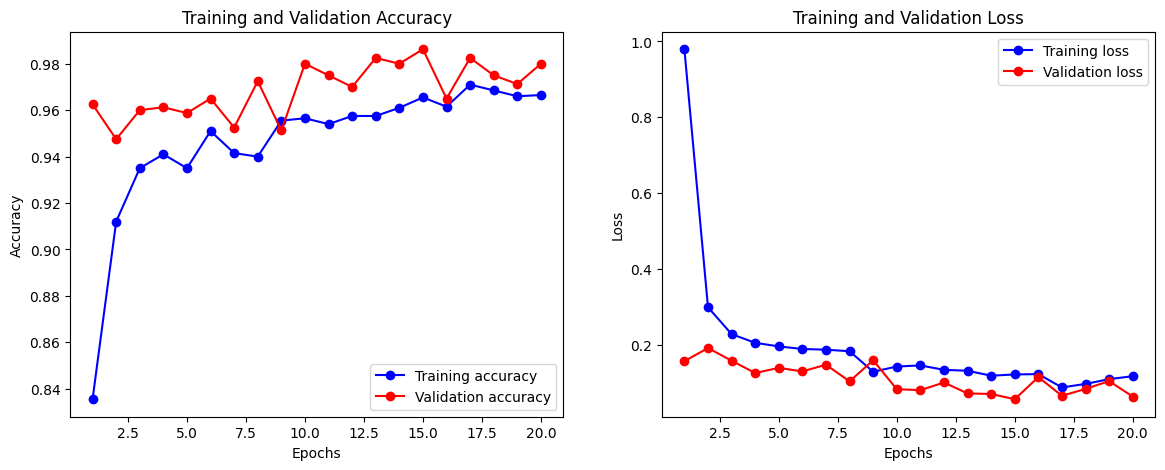

In [ ]:
# Save history_model
with open('/content/drive/My Drive/History_Train_Models/history_vit_model.pkl', 'wb') as file:
    pickle.dump(history_vit_model.history, file)

# Extracting data from history
accuracy = history_vit_model.history['accuracy']
val_accuracy = history_vit_model.history['val_accuracy']
loss = history_vit_model.history['loss']
val_loss = history_vit_model.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the Sets
train_score_vit_model = vit_model.evaluate(train_batches, steps=len(train_batches), verbose=0)
val_score_vit_model   = vit_model.evaluate(validation_batches, steps=len(validation_batches), verbose=0)
test_score_vit_model  = vit_model.evaluate(test_batches, steps=len(test_batches), verbose=0)

print(f'Training loss InceptionV3 model : {train_score_vit_model[0]} ... Training accuracy InceptionV3 model: {train_score_vit_model[1]}')
print(f'Validation loss InceptionV3 model: {val_score_vit_model[0]} ... Validation accuracy InceptionV3 model: {val_score_vit_model[1]}')
print(f'Test loss InceptionV3 model: {test_score_vit_model[0]} ... Test accuracy InceptionV3 model: {test_score_vit_model[1]}')

Training loss InceptionV3 model : 0.04070673882961273 ... Training accuracy InceptionV3 model: 0.9915000200271606
Validation loss InceptionV3 model: 0.06314222514629364 ... Validation accuracy InceptionV3 model: 0.9800000190734863
Test loss InceptionV3 model: 0.10506072640419006 ... Test accuracy InceptionV3 model: 0.9800000190734863
